# PYBOR
PYBOR is a multi-curve interest rate framework and risk engine based on multivariate optimization techniques, written in Python.

**Copyright &copy; 2017 Ondrej Martinsky, All rights reserved**

[www.github.com/omartinsky/pybor](https://github.com/omartinsky/pybor)

In [1]:
%pylab
%matplotlib inline
%run jupyter_helpers
%run yc_framework
figure_width = 16

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


## Pricing Curve Map
Generate pricing curvemap using stochastic short-rate model $dr_t=a(b-r_t)dt + \sigma dW_t$ for curves and tenor/cross-currency basis spreads. This will be our starting point, the curves inside this curvemap will be used only to reprice market instruments.

In [2]:
eval_date = create_date('2017-01-03')

In [3]:
def generate_pricing_curvemap(eval_date):
    random.seed(0)
    pricing_curvemap = CurveMap()
    t = linspace(eval_date+0, eval_date+365*80, 7)
    
    def createCurve(name, r0, speed, mean, sigma):
        return CurveConstructor.FromShortRateModel(name, t, r0, speed, mean, sigma, interpolation=InterpolationMode.CUBIC_LOGDF)
    
    def createCurveFromSpread(baseCurve, name, r0, speed, mean, sigma):
        out = createCurve(name, r0, speed, mean, sigma)
        out.add_another_curve(baseCurve)
        return out
    
    u3m = createCurve('USDLIBOR3M', 0.02, 0.03, 0.035, 5e-4)
    u6m = createCurveFromSpread(u3m, 'USDLIBOR6M', 0.01, 0.03, 0.011, 5e-4)
    u12m = createCurveFromSpread(u6m, 'USDLIBOR12M', 0.01, 0.03, 0.011, 5e-4)
    g3m = createCurveFromSpread(u3m, 'GBPLIBOR3M', 0.03, 0.03, 0.0, 5e-4)
    u1b = createCurve('USD-USDOIS', 0.01, 0.03, 0.011, 5e-4)
    g1b = createCurveFromSpread(u1b, 'GBP-GBPSONIA', 0.005, 0.03, 0.005, 5e-4)
    gu1b = createCurveFromSpread(u1b, 'GBP-USDOIS', 0.001, 0.03, 0.001, 5e-4)
    pricing_curvemap.add_curve(u3m)
    pricing_curvemap.add_curve(u6m)
    pricing_curvemap.add_curve(u12m)
    pricing_curvemap.add_curve(g3m)
    pricing_curvemap.add_curve(g1b)
    pricing_curvemap.add_curve(u1b)
    pricing_curvemap.add_curve(gu1b)
    return pricing_curvemap

In [4]:
pricing_curvemap = generate_pricing_curvemap(eval_date)
usd3m = pricing_curvemap.curves_['USDLIBOR3M']

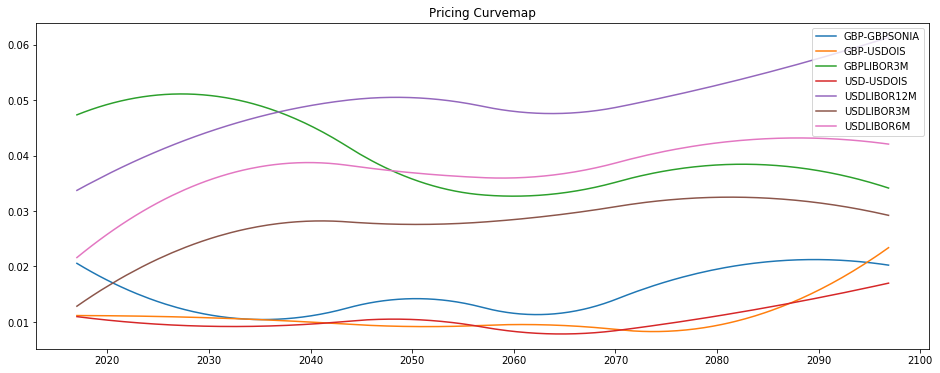

In [5]:

# Display:
figsize(figure_width, 6)
linestyle('solid'), pricing_curvemap.plot(), title('Pricing Curvemap'), legend(), show();

## Interpolation Modes
PYBOR supports three different interpolation methods:
* Linear interpolation of the logarithm of discount factors (aka piecewise-constant in forward-rate space)
* Linear interpolation of the continuously-compounded zero-rates
* Cubic interpolation of the logarithm of discount factors 

Below is the curve interpolated in three different ways:

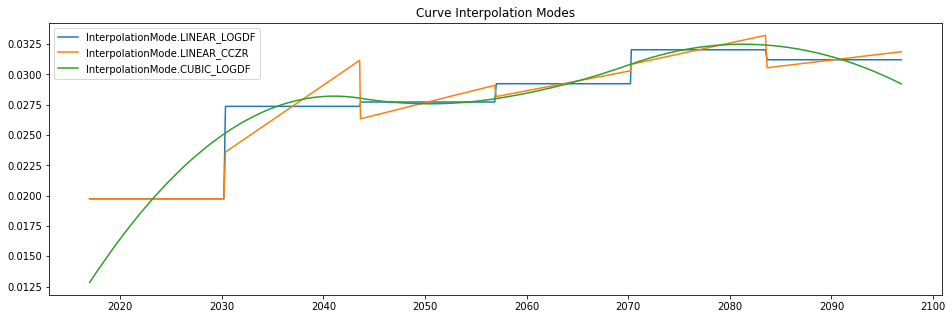

In [6]:
cloned_curve = deepcopy(pricing_curvemap['USDLIBOR3M'])
figsize(figure_width, 5), linestyle('solid'), title('Curve Interpolation Modes')
for i, interpolation in enumerate(InterpolationMode._member_map_.values()):
    cloned_curve.set_interpolator(interpolation)
    cloned_curve.plot(label=interpolation), legend()

## Curve Builder
Create the curve builder. Definitions of curves and market instruments from which these curves are built are loaded from the excel spreadsheet

In [7]:
curve_builder = CurveBuilder('engine_usd_gbp.xlsx', eval_date)

### Instrument Repricing
Use the curve builder (specifically instrument definitions which it contains) to **reprice** instruments from previously created **pricing curve map**.

Instrument *prices* are returned in a structure called *price ladder*

In [8]:
price_ladder = curve_builder.reprice(pricing_curvemap)
type(pricing_curvemap)

yc_curve.CurveMap

### Display price ladder for a specific curve

In [9]:
# Display:
figsize(figure_width, 4)
price_ladder.sublist('USDLIBOR3M').dataframe()
type(price_ladder)


yc_curvebuilder.PriceLadder

### Display instrument par-rates
Every instrument type has a specific relationship between the quoted price $P$ and the par-rate $r$. For instance:

For interest rate swaps, $P = 100 \times r$

For interest rate futures, $P = 10000 \times (1 - r)$

The relationship between interest rate curve in a **zero-rate** space and instrument **par-rates** is often a source of confusion for many people. The below is a graph which illustrates the difference between USDLIBOR3M pricing curve's zero rates vs. par-rates of instruments (e.g. deposits, futures, swaps), which are repriced using this curve.
As we can see, only the par-rates of money market (deposit) instruments correspond to the curve points plotted in a zero-rate space.

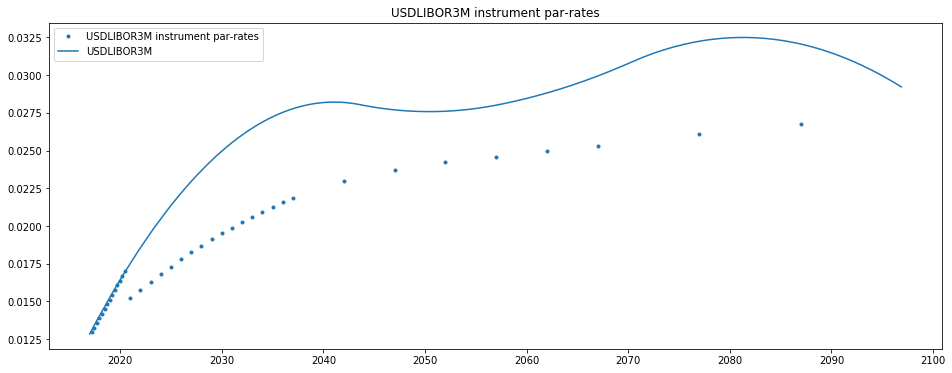

In [10]:
figsize(figure_width, 6)
m, r = curve_builder.get_instrument_rates(price_ladder.sublist('USDLIBOR3M'))
m = [exceldate_to_pydate(int(i)) for i in m]
title('USDLIBOR3M instrument par-rates')
linestyle(' '), plot(m,r,marker='.', label='USDLIBOR3M instrument par-rates')
linestyle('-'), pricing_curvemap['USDLIBOR3M'].plot()
legend();

In [11]:
#price ladder
map = defaultdict(set)
for row in curve_builder.df_curves.iterrows():
    curve, stage = row[0], row[1]['Solve Stage']
    map[stage].add(curve)
stages = [map[i] for i in list(sorted(map))]
stages
stages[0]

{'USD-USDOIS', 'USDLIBOR3M'}

In [57]:
curve_builder = CurveBuilder('engine_usd_gbp.xlsx', eval_date)
#this is an initial guess for the instrument prices
curvemap = curve_builder.create_initial_curvemap(0.02)
#treat the price ladder as input market data for the instrument.  You effectively build the curve and fit to these.
instrument_prices = curve_builder.parse_instrument_prices(price_ladder)

In [61]:
#curve map is a storage object that contains the curves, an ordered dictionary of CurveName to Curve 
curvemap.curves_

OrderedDict([('USDLIBOR3M', <yc_curve.Curve at 0x1325fc3780>),
             ('USDLIBOR6M', <yc_curve.Curve at 0x1328246588>),
             ('USDLIBOR12M', <yc_curve.Curve at 0x132823ee80>),
             ('USD-USDOIS', <yc_curve.Curve at 0x132823ef28>),
             ('GBPLIBOR3M', <yc_curve.Curve at 0x132823efd0>),
             ('GBP-GBPSONIA', <yc_curve.Curve at 0x132824b0b8>),
             ('GBP-USDOIS', <yc_curve.Curve at 0x132824b160>)])

In [70]:
usd_libor_3m = curvemap['USDLIBOR3M']

array([0.99677032, 0.99410144, 0.99045072, 0.98703108, 0.98354891,
       0.97988663, 0.9762417 , 0.97257864, 0.96885927, 0.96495838,
       0.96108637, 0.95720494, 0.9532294 , 0.94915963, 0.94019034,
       0.92319426, 0.90557583, 0.88743033, 0.86879845, 0.84987068,
       0.83068115, 0.81131008, 0.79177974, 0.77226809, 0.75278817,
       0.73340147, 0.71411222, 0.69507789, 0.67629279, 0.65779963,
       0.63958742, 0.55474543, 0.48151116, 0.41865054, 0.36368759,
       0.31497892, 0.27146507, 0.19781855, 0.14249306])

In [60]:
curve_builder.df_curves
#curvebuilder contains curve templates which provides the definition of each instrument that goes into building the curve.
swap = curve_builder.curve_templates[0].instruments[14]
#here swap is the instrument
#for each instrument we can define how we calculate it's par rate, given a curve (initall this is a guess curve)
swap.calc_par_rate(curvemap)
print(swap.name_, swap.calc_par_rate(curvemap))
#the aim of the curve builder/fitter process is to construct a curve(i.e a set of discount factors), 
#so that the par rate of each instrument is equal to the input prices (i.e the market price for the e.g. 4 year swap )
print(instrument_prices[swap.name_], swap.par_rate_from_price(instrument_prices[swap.name_]))

USDLIBOR3M__Swap__4Y 0.015209518696541195
1.520951869640128 0.01520951869640128


In [59]:
curves_for_stage = stages[0]

instruments_for_stage = curve_builder.get_instruments_for_stage(curves_for_stage)
dofs = curvemap.get_all_dofs(curves_for_stage)
#print(dofs)

for i in instruments_for_stage:
    #print(type(i))
    r_actual = i.calc_par_rate(curvemap)
    price = instrument_prices[i.name_]
    r_target = i.par_rate_from_price(price)
    #print(r_actual,price,r_target)

arguments = (curve_builder, curvemap, instrument_prices, curves_for_stage, instruments_for_stage)
bounds = (zeros(len(dofs)), numpy.inf * ones(len(dofs)))
solution = scipy.optimize.least_squares(fun=calc_residuals, x0=dofs, args=arguments, bounds=bounds)
print(solution.x)
assert isinstance(solution, scipy.optimize.OptimizeResult)

if not solution.success:
    raise BaseException(solution.message)
curvemap.set_all_dofs(curves_for_stage, solution.x)

[0.99677032 0.99410144 0.99045072 0.98703108 0.98354891 0.97988663
 0.9762417  0.97257864 0.96885927 0.96495838 0.96108637 0.95720494
 0.9532294  0.94915963 0.94019034 0.92319426 0.90557583 0.88743033
 0.86879845 0.84987068 0.83068115 0.81131008 0.79177974 0.77226809
 0.75278817 0.73340147 0.71411222 0.69507789 0.67629279 0.65779963
 0.63958742 0.55474543 0.48151116 0.41865054 0.36368759 0.31497892
 0.27146507 0.19781855 0.14249306 0.99996955 0.99905715 0.99820776
 0.99726979 0.99453105 0.98905884 0.97845255 0.96815815 0.95812655
 0.94839132 0.93890424 0.9296457  0.92057223 0.91171516 0.90303181
 0.89450523 0.88609623 0.87783493 0.86968288 0.86162537 0.85362641
 0.84571594 0.83785878 0.83004216 0.82223249 0.78329458 0.74373104
 0.70539117 0.67139323 0.6432529  0.61806817 0.56448678 0.50135788]


In [34]:
# calculate jacobian matrix
bump_size = 1e-8
final_solution = curvemap.get_all_dofs(curvemap.keys())
all_curves = [curve_template.curve_name for curve_template in curve_builder.curve_templates]
all_instruments = curve_builder.get_instruments_for_stage(all_curves)
arguments = (curve_builder, curvemap, instrument_prices,all_curves, all_instruments)
e0 = array(calc_residuals(final_solution, *arguments))
jacobian_dIdP = []

In [36]:
len(final_solution)
curvemap.keys()
all_curves

['USDLIBOR3M',
 'USDLIBOR6M',
 'USDLIBOR12M',
 'USD-USDOIS',
 'GBPLIBOR3M',
 'GBP-GBPSONIA',
 'GBP-USDOIS']

In [23]:
for i in range(len(final_solution)):
    bump_vector = zeros(len(final_solution))
    bump_vector[i] += bump_size
    e = array(calc_residuals(final_solution + bump_vector, *arguments))
    jacobian_dIdP.append((e - e0) / bump_size)
# this jacobian_dIdP contains dI/dP.  Rows=Pillars  Cols=Instruments
# after inversion, it will contain dP/dI.   Rows=Instruments   Cols=Pillars
jacobian_dIdP = matrix(jacobian_dIdP)

In [26]:
jacobian_dIdP.shape

(234, 234)

### Curve Building
Build a brand new collection of curves from the instrument prices. This will take few seconds to complete ... 

In [10]:
build_output = curve_builder.build_curves(price_ladder)

Solving stage 1/5 containing curves USD-USDOIS, USDLIBOR3M (72 pillars)
Solving stage 2/5 containing curves USDLIBOR6M (30 pillars)
Solving stage 3/5 containing curves USDLIBOR12M (30 pillars)
Solving stage 4/5 containing curves GBP-GBPSONIA, GBPLIBOR3M (72 pillars)
Solving stage 5/5 containing curves GBP-USDOIS (30 pillars)
Done


Below is the comparison of curves which we have just built (**solid lines**) with pricing curves (**dotted lines**). These lines should be as close to each other as possible.

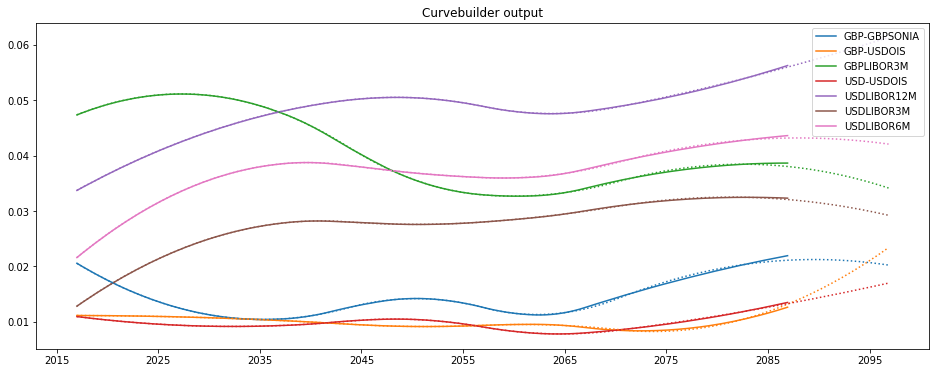

In [11]:
# Display:
figsize(figure_width, 6)
title('Curvebuilder output')
linestyle('solid'), build_output.output_curvemap.plot(), legend()
linestyle('dotted'), pricing_curvemap.plot();

### Instrument/Pillar Jacobian Matrix
The optimizer is using gradient-descent method to minimize error between instrument par-rates calculated from the curves which are subject to this optimization and the input instrument par-rates. In order to do this, optimizer calculates derivative ${\delta (I-I') / \delta P}$, where $I$ is the actual instrument par-rate, $I'$ is the target instrument par-rate and $P$ is the pillar value from the curve (practically speaking, the discount factor).

Jacobian matrix which is a by-product of the curve building process can be then used for risk calculation purposes and it will be illustrated lated.

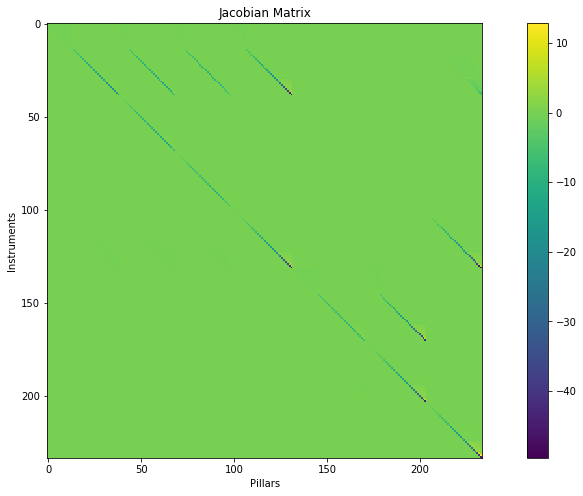

In [12]:
jacobian_dPdI = inv(build_output.jacobian_dIdP)
# Display:
figsize(figure_width, 8)
title("Jacobian Matrix"), xlabel('Pillars'), ylabel('Instruments')
imshow(jacobian_dPdI), colorbar();

## Risk Calculator
Risk calculator is constructed from the **curve builder** (which contains curve definitions and market conventions) and **build output** (which contains curves and the jacobian matrix).

In [13]:
risk_calculator = RiskCalculator(curve_builder, build_output)

Let's define a convenience function which will bump par-rate of a specific instrument by the given amount of basis points and visualise the effect on all curves.

In [14]:
def visualise_bump(instrument_search_string, bumpsize):
    instruments, bumpsize = risk_calculator.find_instruments(instrument_search_string), bumpsize  
    curvemap_bump = risk_calculator.get_bumped_curvemap(instruments, bumpsize, BumpType.JACOBIAN_REBUILD)

    # Display:
    figsize(figure_width, 6)
    linestyle('solid'), build_output.output_curvemap.plot(), legend()
    linestyle('dashed'), curvemap_bump.plot()
    title("Effect of bumping instrument %s" % instrument_search_string)

### Bumping Market Instruments

Bumping **market instruments** (such as those which define USD LIBOR 3M neutral curve) will cause parallel shift of all other curves which are defined as a basis from this curve

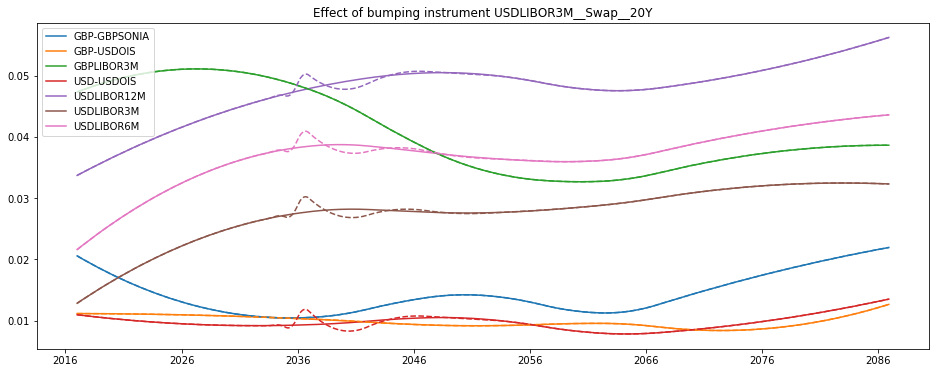

In [15]:
visualise_bump('USDLIBOR3M__Swap__20Y', 1e-4)

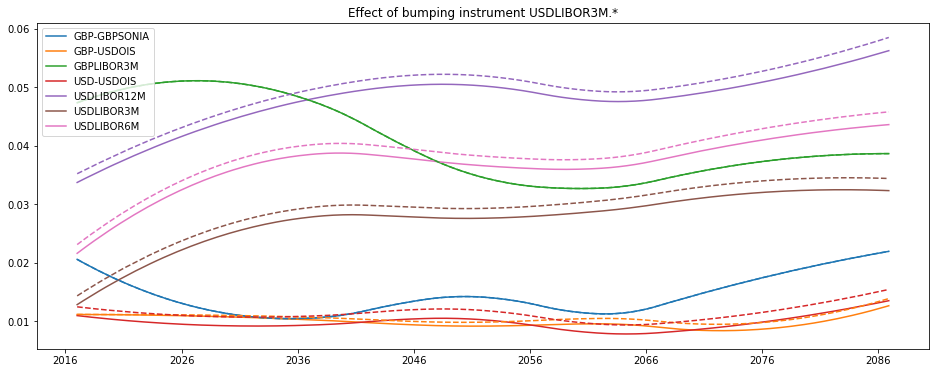

In [16]:
visualise_bump('USDLIBOR3M.*', 15e-4)

## Bumping Basis Instruments

Bumping **basis instruments** (USD LIBOR 6M) will cause movement in a USD LIBOR 6M basis curve

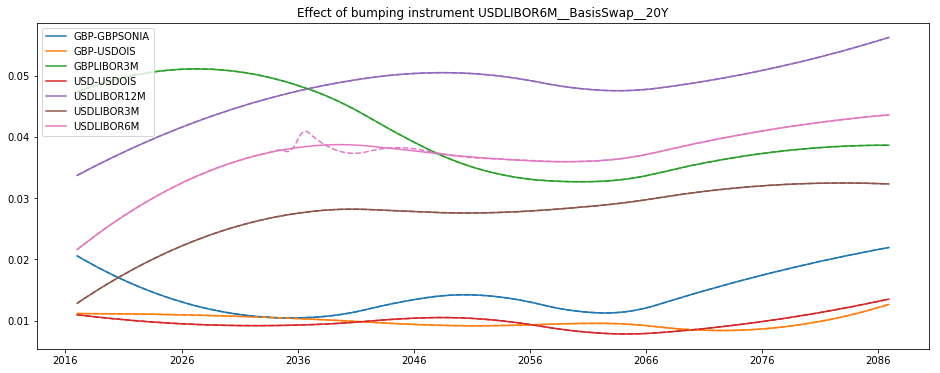

In [17]:
visualise_bump('USDLIBOR6M__BasisSwap__20Y', 1e-4)

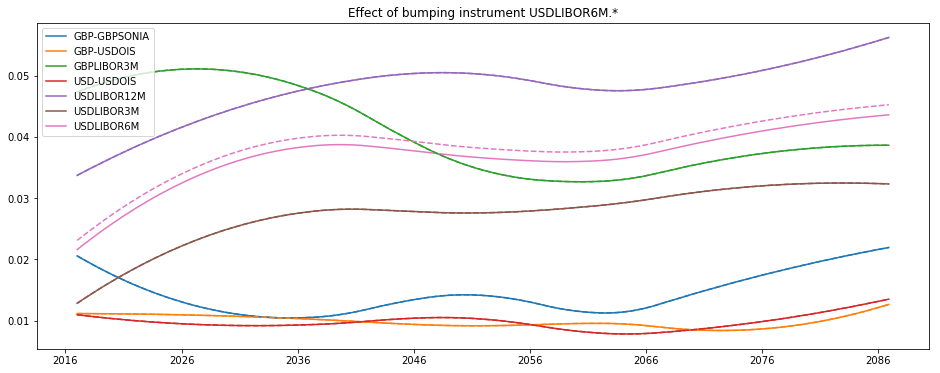

In [18]:
visualise_bump('USDLIBOR6M.*', 15e-4)